# Personalized correlations PNP3

 *Wake up glucose vs diet the day before*

The idea is that wakeup glucose is not the same on different days for the same person. I want to understand if it is due to the dietal behavior the day before. Also I want to see if associations between the food in the previous day and the wakeup glucose are different for different people. PNP3 cohort is suitable for this purpose because each person had more than 100 days of CGM connections.

I have to start with computing the wakeup glucose for all the people and each day. The method is to use the time between 6 and 7 unless a person logged the food at this time. Also I have to filter out days and people who logged any food after midnight.

In [1]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

In [121]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [212]:
import seaborn as sb

## Calculating wakeup glucose

In [5]:
cgmdf = cgml.get_data(study_ids=[3,49]).df
cgmdf = cgml._remove_first_day_of_connections(cgmdf)

In [6]:
cgmdf = cgmdf.reset_index()
cgmdf['hour'] = cgmdf.Date.dt.hour
cgmdf = cgmdf.set_index('Date')
cgmdf.index = cgmdf.index.tz_localize(None)

In [7]:
cgmdf['RegistrationCode'].nunique()

263

In [3]:
adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})

In [8]:
adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

In [10]:
cgm_adj['RegistrationCode'].nunique()

219

In [11]:
log = dll.get_data(study_ids=[3,49]).df

In [12]:
logdf = dll.add_nutrients(log, ['energy_kcal'])

In [13]:
logdf = dll.squeeze_log(logdf)

In [14]:
logdf = logdf.reset_index()
logdf['Day'] = logdf['Date'].dt.date

In [15]:
logdf = logdf[logdf['energy_kcal'] != 0]

In [16]:
logdf.head()

,RegistrationCode,Date,energy_kcal,weight,meal_type,Day
0,111527,2017-10-06 09:46:44+03:00,2.500000,490.000000,Beverage,2017-10-06
1,111527,2017-10-06 11:48:01+03:00,147.000000,560.000000,Meal,2017-10-06
2,111527,2017-10-06 11:53:29+03:00,78.057000,210.000000,Beverage,2017-10-06
5,111527,2017-10-06 14:25:24+03:00,740.724492,605.200001,Meal,2017-10-06
7,111527,2017-10-06 17:11:29+03:00,136.500000,296.000000,Snack,2017-10-06


In [53]:
firstmeals = pd.DataFrame(logdf.groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
firstmeals

breakfast_ts
RegistrationCode Day                                        
111527           2017-10-06        2017-10-06 09:46:44+03:00
                 2017-10-07        2017-10-07 09:34:22+03:00
                 2017-10-08        2017-10-08 08:56:41+03:00
                 2017-10-09        2017-10-09 01:02:14+03:00
                 2017-10-14        2017-10-14 09:03:31+03:00
...                                                      ...
997735           2019-10-28 2019-10-28 08:29:46.061000+02:00
                 2019-10-29 2019-10-29 07:30:22.533000+02:00
                 2019-10-30 2019-10-30 08:00:24.974000+02:00
                 2019-11-02 2019-11-02 08:00:34.291000+02:00
                 2019-11-03 2019-11-03 06:00:31.647000+02:00

[50492 rows x 1 columns]

In [54]:
firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]

In [55]:
firstmeals = firstmeals.reset_index('Day')

In [56]:
firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])

In [57]:
firstmeals = firstmeals.set_index('Day', append=True)

In [58]:
firstmeals.shape

(44884, 1)

In [59]:
cgm_adj.shape

(2965212, 5)

In [21]:
cgm_adj['Day'] = cgm_adj.index.date

In [26]:
cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])

In [40]:
firstmeals.index.get_level_values(1).dtype

dtype('<M8[ns]')

In [88]:
cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])

In [89]:
cgm_fm.shape

(2349082, 6)

In [90]:
cgm_fm

ConnectionID  ...                     breakfast_ts
RegistrationCode Day                      ...                                 
111527           2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
...                                  ...  ...                              ...
997735           2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00

[2349082 rows x 6 columns]

In [91]:
cgm_fm = cgm_fm[(cgm_fm['hour'] >= 5) & (cgm_fm['hour'] <= 6)]
cgm_fm.shape

(200553, 6)

In [93]:
cgm_fm = cgm_fm[((cgm_fm['hour'] ==5) & (cgm_fm['breakfast_ts'].dt.hour == 6)) | 
((cgm_fm['hour'] ==6) & (cgm_fm['breakfast_ts'].dt.hour >= 7)) ]

In [133]:
wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename('wakeup_glucose'))

In [134]:
wakeup_glucose = wakeup_glucose.reset_index()

In [135]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def interquartile_range(x):
    return q3(x) - q1(x)

f = {'wakeup_glucose': ['median', 'std', q1,q3, interquartile_range]}

In [136]:
morn_gluc_distr = wakeup_glucose.groupby('RegistrationCode').agg(f)

In [137]:
morn_gluc_distr.sample(10)

wakeup_glucose             ...                                
                         median        std  ...          q3 interquartile_range
RegistrationCode                            ...                                
173854                87.145833  14.927984  ...   91.647321           12.959821
772380                96.250000   5.252915  ...  100.700000            7.562500
252002                97.649573   9.253903  ...  105.050000           12.130682
794542               126.634615  12.311187  ...  132.849359           10.974359
130279                99.375000  11.034922  ...  105.468750           10.883523
132178               109.375000   8.970829  ...  114.669643           11.794643
439484                95.250000  10.592360  ...   98.919643            8.453734
742096                92.333333   5.377542  ...   95.603147            7.487762
997427               107.766667   7.604173  ...  111.968531            8.697698
64952                 89.289773   8.936098  ...   94.250000            9.326705

[10 rows x 5 columns]

In [108]:
morn_gluc_distr.columns = morn_gluc_distr.columns.droplevel()

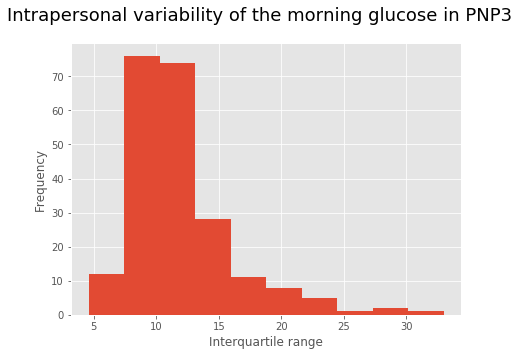

In [122]:
fig = plt.figure(figsize=(7,5))
fig.suptitle('Intrapersonal variability of the morning glucose in PNP3', fontsize=18)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Interquartile range')
morn_gluc_distr['interquartile_range'].plot.hist()

In [123]:
morn_gluc_distr['interquartile_range'].mean()

11.936180075658099

I should look at this values before and after the intervention and compare changes for the two diets. 

In [152]:
wakeup_glucose.shape

(25799, 4)

For how many days did people wear CGM sensor?

In [143]:
count = wakeup_glucose.groupby('RegistrationCode')['Day'].count()

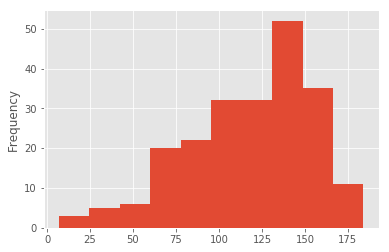

In [144]:
count.plot.hist()

In [149]:
rc_to_keep = count[count >= 50].index

Let's take all people with at least 50 days of  connections.

In [153]:
wakeup_glucose = wakeup_glucose.set_index('RegistrationCode').loc[rc_to_keep]

In [176]:
wakeup_glucose.shape

(25432, 3)

## Dietary features from the day before

Dietary features to test the correlations on:
'alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'carbs/fat', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'

In [128]:
logdf = dll.add_nutrients(log,['alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'energy_kcal', 
                       'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'])

In [130]:
logdf = dll.squeeze_log(logdf)
logdf.head()

sodium_mg  ...  meal_type
RegistrationCode Date                                  ...           
111527           2017-10-06 09:46:44+03:00      9.800  ...   Beverage
                 2017-10-06 11:48:01+03:00    311.000  ...       Meal
                 2017-10-06 11:53:29+03:00     64.995  ...   Beverage
                 2017-10-06 13:17:55+03:00     14.400  ...   Beverage
                 2017-10-06 14:10:52+03:00     19.200  ...   Beverage

[5 rows x 11 columns]

In [131]:
logdf = logdf.reset_index()

In [155]:
logdf['Day'] = logdf['Date'].dt.date
logdf.head()

,RegistrationCode,Date,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,weight,caffeine_mg,meal_type,Day
0,111527,2017-10-06 09:46:44+03:00,9.800,0.0,0.0,0.050,0.300,0.000,0.00,2.500,490.0,112.5,Beverage,2017-10-06
1,111527,2017-10-06 11:48:01+03:00,311.000,0.0,0.0,6.040,6.700,15.220,0.56,147.000,560.0,0.0,Meal,2017-10-06
2,111527,2017-10-06 11:53:29+03:00,64.995,0.0,0.0,3.906,4.284,6.363,0.00,78.057,210.0,50.4,Beverage,2017-10-06
3,111527,2017-10-06 13:17:55+03:00,14.400,0.0,0.0,0.000,0.000,0.000,0.00,0.000,720.0,0.0,Beverage,2017-10-06
4,111527,2017-10-06 14:10:52+03:00,19.200,0.0,0.0,0.000,0.000,0.000,0.00,0.000,960.0,0.0,Beverage,2017-10-06


Let's start with correlating with the total amounts per day.

In [158]:
totaldaylog = logdf.drop(columns=['weight', 'meal_type']).groupby(['RegistrationCode', 'Day']).sum()

In [170]:
totaldaylog.shape

(50505, 9)

On some of the days log is not good enough, people logged too little calories per day which can't be representative. 

In [173]:
logdf[(logdf['RegistrationCode'] == '168236') & (logdf['Day'] == datetime.date(2018,9,29))]

,RegistrationCode,Date,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,weight,caffeine_mg,meal_type,Day
23126,168236,2018-09-29 08:18:55+03:00,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0,0.0,Meal,2018-09-29


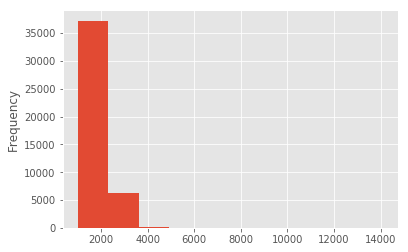

In [174]:
totaldaylog['energy_kcal'].plot.hist()

I take the threshold of 1000 kcal per day.

In [172]:
totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= 1000]

In [180]:
totaldaylog = totaldaylog.reset_index('Day')
totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)

,Day,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
RegistrationCode,,,,,,,,,,
111527,2017-10-07,3522.806605,2.637400,0.0,79.195531,73.908813,149.287278,11.494648,1628.551492,383.4
111527,2017-10-08,1823.482200,8.276208,0.0,68.169205,40.689566,97.676125,4.879275,1170.992650,365.5
111527,2017-10-09,875.554000,1.964900,0.0,53.919700,51.124900,116.313900,8.873000,1169.040000,328.5
111527,2017-11-06,2046.856887,7.224420,0.0,90.674065,57.076296,156.910187,10.300168,1672.065725,265.8
111527,2017-11-07,1454.499167,36.356777,0.0,36.157640,34.195410,169.203500,8.200050,1146.560500,488.4
...,...,...,...,...,...,...,...,...,...,...
997735,2019-07-21,1779.774261,32.657460,0.0,78.548838,62.383786,144.315955,13.150530,1555.777802,108.0
997735,2019-10-29,2426.480840,10.161800,0.0,127.763931,93.380938,45.815866,14.380857,1742.416510,126.7
997735,2019-10-30,2289.286330,15.839225,0.0,104.998046,98.818427,68.775400,21.407009,1676.275800,126.7


In [198]:
totaldaylog.sample(5)

,Day,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
RegistrationCode,,,,,,,,,,
981727,2019-08-08,2424.795640,40.098200,0.0,99.814172,81.399348,124.148724,25.930744,1747.410584,0.0
300747,2019-01-15,3150.326818,9.814900,0.0,85.528895,81.238474,184.052271,17.478592,1832.763047,105.6
292738,2017-11-23,2868.206501,27.647440,0.0,113.650835,69.300170,56.320150,23.081498,1550.963600,122.5
572984,2017-12-26,2503.238315,18.803698,0.0,67.202552,104.289861,162.107160,12.860652,1710.389955,84.0
992638,2017-11-08,5845.353760,21.838830,0.0,91.036144,139.762957,205.031590,42.916298,2209.011860,84.0


In [182]:
totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])

In [184]:
data = pd.merge(wakeup_glucose, totaldaylog, on=['RegistrationCode', 'Day'])

In [191]:
data.columns

Index(['Day', 'hour', 'wakeup_glucose', 'sodium_mg', 'sugarstotal_g',
       'alcohol_g', 'totallipid_g', 'protein_g', 'carbohydrate_g',
       'totaldietaryfiber_g', 'energy_kcal', 'caffeine_mg'],
      dtype='object')

Normality testing method

In [199]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
for column in data.columns:
    stat, p = shapiro(data.loc['300747'][column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(column, ': Sample looks Gaussian (fail to reject H0)')
    else:
        print(column, ': Sample does not look Gaussian (reject H0)')

Statistics=0.878, p=0.000
Day : Sample does not look Gaussian (reject H0)
Statistics=0.303, p=0.000
hour : Sample does not look Gaussian (reject H0)
Statistics=0.993, p=0.872
wakeup_glucose : Sample looks Gaussian (fail to reject H0)
Statistics=0.939, p=0.000
sodium_mg : Sample does not look Gaussian (reject H0)
Statistics=0.936, p=0.000
sugarstotal_g : Sample does not look Gaussian (reject H0)
Statistics=0.275, p=0.000
alcohol_g : Sample does not look Gaussian (reject H0)
Statistics=0.990, p=0.599
totallipid_g : Sample looks Gaussian (fail to reject H0)
Statistics=0.970, p=0.013
protein_g : Sample does not look Gaussian (reject H0)
Statistics=0.975, p=0.035
carbohydrate_g : Sample does not look Gaussian (reject H0)
Statistics=0.970, p=0.013
totaldietaryfiber_g : Sample does not look Gaussian (reject H0)
Statistics=0.955, p=0.001
energy_kcal : Sample does not look Gaussian (reject H0)
Statistics=0.983, p=0.157
caffeine_mg : Sample looks Gaussian (fail to reject H0)


In [204]:
data.loc['300747']

,Day,hour,wakeup_glucose,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
RegistrationCode,,,,,,,,,,,,
300747,2018-08-22,6,111.678571,2305.815000,53.993700,0.000000,57.664016,89.605886,169.629203,16.050894,1584.865036,294.0
300747,2018-08-23,6,110.178571,1816.988360,78.933200,0.000000,55.232780,67.450990,256.274824,39.284406,1862.066560,273.6
300747,2018-08-24,5,101.678571,2051.087960,16.444537,12.870000,54.576964,43.038302,185.265700,25.555340,1499.187452,297.5
300747,2018-08-25,6,86.928571,2580.802970,2.384970,0.000000,88.235359,84.283468,291.938547,20.777307,2320.677391,220.8
300747,2018-08-26,6,102.178571,3147.840300,67.483677,0.000000,93.202396,79.141718,262.754260,41.357317,2243.451261,220.8
...,...,...,...,...,...,...,...,...,...,...,...,...
300747,2019-06-17,6,119.000000,1268.445790,37.160850,0.000000,57.303258,46.715409,157.550100,20.020413,1330.808090,160.8
300747,2019-06-18,6,108.250000,1516.307960,37.369305,0.000000,45.457475,54.206257,165.380166,29.333185,1288.655040,0.0
300747,2019-09-21,6,113.904762,1997.973050,22.705873,1.915126,65.635501,58.708488,99.060971,12.368849,1262.858607,139.2


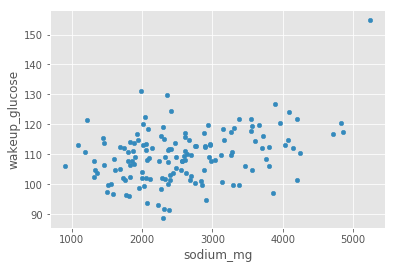

In [250]:
data.loc['132178'].plot.scatter(x='sodium_mg', y='wakeup_glucose')

In PNP3 patients probably avoided alcohol due to the diet. I should exclude this feature from the correlation analysis.

In [222]:
data.loc['111527'].drop(columns=['Day', 'hour','alcohol_g'])

,wakeup_glucose,sodium_mg,sugarstotal_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
RegistrationCode,,,,,,,,,
111527,103.071429,2000.838539,6.538000,79.052895,73.624292,231.320475,12.664168,1919.714530,558.00
111527,98.071429,1691.501330,6.313964,58.201139,50.789459,194.751503,11.263018,1517.150220,562.50
111527,101.321429,2289.811585,5.414400,73.305995,79.098687,265.900131,13.546815,2087.215480,328.50
111527,107.071429,1862.517280,25.698000,44.786748,48.809778,160.317880,16.807222,1317.762920,328.50
111527,106.071429,3063.713740,83.697100,70.233976,78.098902,231.655018,12.343034,1871.107020,305.22
...,...,...,...,...,...,...,...,...,...
111527,92.750000,2134.218235,5.893680,76.650175,72.475867,80.171469,10.966628,1255.593851,162.00
111527,101.250000,2309.425627,4.671120,95.310702,58.810990,109.272894,15.051371,1549.925101,324.00
111527,114.000000,1282.174526,5.145570,109.319287,45.313389,98.072756,11.208888,1555.377740,243.00


In [229]:
pearsoncorr = data.loc['111527'].drop(columns=['Day', 'hour', 'alcohol_g']).corr(method='pearson')['wakeup_glucose']
pearsoncorr

wakeup_glucose         1.000000
sodium_mg              0.004212
sugarstotal_g          0.115427
totallipid_g          -0.185092
protein_g             -0.002361
carbohydrate_g         0.070137
totaldietaryfiber_g    0.035468
energy_kcal           -0.099591
caffeine_mg            0.031436
Name: wakeup_glucose, dtype: float64

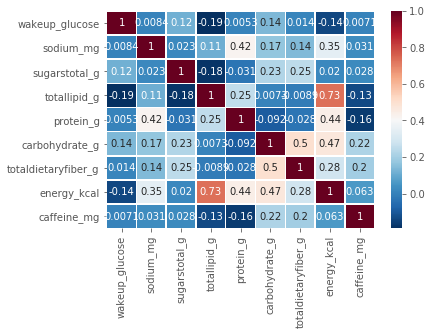

In [227]:
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [236]:
from scipy.stats import pearsonr, spearmanr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues

In [235]:
calculate_pvalues(data.loc['111527']) 

,hour,wakeup_glucose,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
hour,0,0.0189,0.7371,0.404,0.1191,0.7549,0.6032,0.6588,0.0208,0.7704,0.0222
wakeup_glucose,0.0189,0,0.9615,0.1841,0.164,0.0323,0.9784,0.4207,0.6841,0.2523,0.7184
sodium_mg,0.7371,0.9615,0,0.1948,0.8132,0.0717,0,0.0333,0.161,0,0.2908
sugarstotal_g,0.404,0.1841,0.1948,0,0.1609,0.0217,0.9274,0,0.0076,0.3416,0.4028
alcohol_g,0.1191,0.164,0.8132,0.1609,0,0.0507,0.3678,0.0361,0.1513,0.9646,0.245
totallipid_g,0.7549,0.0323,0.0717,0.0217,0.0507,0,0.0004,0.0156,0.6184,0,0.0227
protein_g,0.6032,0.9784,0,0.9274,0.3678,0.0004,0,0.1445,0.6505,0,0.0234
carbohydrate_g,0.6588,0.4207,0.0333,0,0.0361,0.0156,0.1445,0,0,0,0
totaldietaryfiber_g,0.0208,0.6841,0.161,0.0076,0.1513,0.6184,0.6505,0,0,0.0031,0.0026
energy_kcal,0.7704,0.2523,0,0.3416,0.9646,0,0,0,0.0031,0,0.3985


In [237]:
calculate_pvalues(data.loc['111527']) 

,hour,wakeup_glucose,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
hour,0,0.0115,0.3917,0.485,0.0652,0.6374,0.5703,0.605,0.0705,0.9927,0.064
wakeup_glucose,0.0115,0,0.923,0.1773,0.0783,0.0278,0.9512,0.1126,0.8684,0.1116,0.9351
sodium_mg,0.3917,0.923,0,0.794,0.8591,0.1912,0,0.0478,0.098,0,0.7232
sugarstotal_g,0.485,0.1773,0.794,0,0.5769,0.0393,0.7193,0.0083,0.0034,0.8196,0.7506
alcohol_g,0.0652,0.0783,0.8591,0.5769,0,0.6556,0.2193,0.0061,0.2389,0.2907,0.4625
totallipid_g,0.6374,0.0278,0.1912,0.0393,0.6556,0,0.0033,0.9331,0.9188,0,0.1353
protein_g,0.5703,0.9512,0,0.7193,0.2193,0.0033,0,0.2898,0.7468,0,0.0577
carbohydrate_g,0.605,0.1126,0.0478,0.0083,0.0061,0.9331,0.2898,0,0,0,0.0099
totaldietaryfiber_g,0.0705,0.8684,0.098,0.0034,0.2389,0.9188,0.7468,0,0,0.0009,0.021
energy_kcal,0.9927,0.1116,0,0.8196,0.2907,0,0,0,0.0009,0,0.472


In [240]:
data.head()

,wakeup_glucose,sodium_mg,sugarstotal_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,caffeine_mg
RegistrationCode,,,,,,,,,
111527,103.071429,2000.838539,6.538000,79.052895,73.624292,231.320475,12.664168,1919.71453,558.00
111527,98.071429,1691.501330,6.313964,58.201139,50.789459,194.751503,11.263018,1517.15022,562.50
111527,101.321429,2289.811585,5.414400,73.305995,79.098687,265.900131,13.546815,2087.21548,328.50
111527,107.071429,1862.517280,25.698000,44.786748,48.809778,160.317880,16.807222,1317.76292,328.50
111527,106.071429,3063.713740,83.697100,70.233976,78.098902,231.655018,12.343034,1871.10702,305.22


In [239]:
data = data.drop(columns=['Day', 'hour', 'alcohol_g'])

In [249]:
for rc in data.index.unique():
    for column in data.columns:
        pearson = pearsonr(data.loc[rc]['wakeup_glucose'], data.loc[rc][column])
        if abs(pearson[0]) > 0.3 and pearson[1] < 0.05 and column != 'wakeup_glucose':
            print(rc, column, pearson)

12752 caffeine_mg (0.352731094945485, 0.0016531339040625236)
132178 sodium_mg (0.36288815039490574, 7.263639574688936e-06)
133828 protein_g (0.3077226925263878, 0.011953992807919549)
133828 totaldietaryfiber_g (-0.3004777230455447, 0.014230608586051194)
136529 energy_kcal (0.3137708497608197, 0.0005402830670039146)
199369 carbohydrate_g (0.30450689032431055, 0.00013662045957123835)
207579 totaldietaryfiber_g (0.3795477241358315, 0.0016719441742114344)
216303 energy_kcal (0.40696519537433434, 0.000519964121282894)
24153 caffeine_mg (-0.32458152654713684, 0.00575146836986471)
243235 protein_g (0.31397215971795667, 0.006085372434603522)
287239 energy_kcal (0.30030371905268066, 0.0002683584768583598)
2893 protein_g (0.3203623008982176, 0.0005110626931836191)
300747 sodium_mg (-0.32097171345153597, 0.0005931772716818834)
309076 energy_kcal (0.35520884335010827, 0.000550232488611803)
313112 totaldietaryfiber_g (-0.31853113091596286, 0.02136743377235356)
328155 carbohydrate_g (-0.307881998182

In [256]:
for rc in data.index.unique():
    for column in data.columns:
        spearman = spearmanr(data.loc[rc]['wakeup_glucose'], data.loc[rc][column])
        if abs(spearman[0]) > 0.3 and spearman[1] < 0.05 and column != 'wakeup_glucose':
            print(rc, column, spearman)

12752 caffeine_mg SpearmanrResult(correlation=0.436132981144565, pvalue=7.342704836840676e-05)
133828 protein_g SpearmanrResult(correlation=0.30233067876272357, pvalue=0.013615427102934698)
136529 energy_kcal SpearmanrResult(correlation=0.37295872996225693, pvalue=3.1917143347781134e-05)
154750 totaldietaryfiber_g SpearmanrResult(correlation=-0.31614558858043884, pvalue=0.0021402288222861273)
158748 carbohydrate_g SpearmanrResult(correlation=0.31804500047693696, pvalue=0.0008427240786716317)
158748 caffeine_mg SpearmanrResult(correlation=0.3254169677165141, pvalue=0.0006257750829450217)
199369 carbohydrate_g SpearmanrResult(correlation=0.3099267774610361, pvalue=0.00010207325617196608)
207579 totaldietaryfiber_g SpearmanrResult(correlation=0.3868233725685297, pvalue=0.001334704492469256)
215130 carbohydrate_g SpearmanrResult(correlation=0.310588864920942, pvalue=3.754044121062535e-05)
216303 sodium_mg SpearmanrResult(correlation=0.38299777333931173, pvalue=0.0011617625926831066)
216303

In [244]:
pearsonr(data.loc['111527']['wakeup_glucose'], data.loc['111527']['totallipid_g'])

(-0.1850918415032243, 0.03226954982586139)

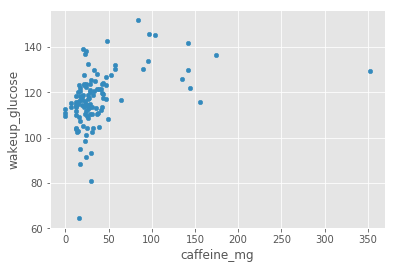

In [260]:
data.loc['93282'].plot.scatter(x='caffeine_mg', y='wakeup_glucose')

In [262]:
pearsonr(data['wakeup_glucose'], data['totallipid_g'])

(0.10863124248225978, 1.5116768004638453e-60)